# LAB 6 : Feature selection methods
All the different approaches to feature selection can be grouped into mainly two families of methods. There are unsupervised and supervised methods. The latter can be further divided into the wrapper and filter mothods. Let’s discuss them one by one.

In this lab, your task is to carefully review all instructions and fill the empty code cells with the necessary code to ensure everything functions correctly.


## Import necessary libraries

Requirement:
- pip install mlxtend
- pip install sklearn-genetic-opt

In [1]:
!pip install mlxtend
!pip install sklearn-genetic-opt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 6.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.datasets import load_iris, load_breast_cancer, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn_genetic import GAFeatureSelectionCV
warnings.filterwarnings("ignore")


# About the dataset



**The Forest Cover Type Dataset (Covertype)** contains data on forest cover types based on cartographic variables.

It is composed of 110,393 instances and 54 features (including continuous, categorical, and binary features) that represent various environmental factors, making it ideal for exploring feature selection.

The classification task is to predict the type of forest cover (seven possible types).

Here is a description of each forest cover class in the used dataset:

**Spruce/Fir (Class 1):** A forest type primarily composed of spruce and fir trees, which are common in colder climates and higher elevations. These trees are known for their needle-like leaves and are typically evergreen.

**Lodgepole Pine (Class 2):** Dominated by lodgepole pine trees, which grow well in diverse soil types and are highly adaptable. Lodgepole pines are resilient, often thriving in areas prone to wildfires as their cones require heat to open and release seeds.

**Ponderosa Pine (Class 3):** Ponderosa pine forests are found at lower elevations and warmer climates. These trees are tall with thick bark and long needles, often providing valuable habitats and resources for wildlife.

**Cottonwood/Willow (Class 4):** A mix of cottonwood and willow trees, often found near water sources like rivers or lakes due to their preference for moist soils. These trees are deciduous, shedding leaves seasonally, and play an essential role in riparian ecosystems.

**Aspen (Class 5):** Aspen forests consist mainly of aspen trees, known for their smooth, white bark and leaves that tremble in the wind. Aspens grow in clonal colonies and are usually found in cooler, moist environments.

**Douglas-fir (Class 6):** A forest type dominated by Douglas-fir trees, which are common in the western U.S. These tall trees with conical shapes are important for the timber industry and thrive in both dry and wet climates.

**Krummholz (Class 7):** Known as "twisted wood," Krummholz forests are made up of trees that are stunted and gnarled due to harsh environmental conditions, such as strong winds and cold temperatures. They are commonly found at the treeline in mountainous areas.

In [3]:
# Load the dataset
data = fetch_openml("Covertype", version=1)

initial_data = pd.DataFrame(data.data)
initial_data['class'] = data.target

print(initial_data.dtypes)

#select Continuous and Categorical features
continuous_features = initial_data.drop(columns='class').select_dtypes(['int64', 'float64'])
categorical_features = initial_data.drop(columns='class').select_dtypes(['object'])

#Print their shape
print(continuous_features.shape)
print(categorical_features.shape)

elevation                                int64
aspect                                   int64
slope                                    int64
horizontal_distance_to_hydrology         int64
Vertical_Distance_To_Hydrology           int64
Horizontal_Distance_To_Roadways          int64
Hillshade_9am                            int64
Hillshade_Noon                           int64
Hillshade_3pm                            int64
Horizontal_Distance_To_Fire_Points       int64
wilderness_area1                         int64
wilderness_area2                         int64
wilderness_area3                         int64
wilderness_area4                         int64
soil_type_1                           category
soil_type_2                           category
soil_type_3                           category
soil_type_4                           category
soil_type_5                           category
soil_type_6                           category
soil_type_7                           category
soil_type_8  

# Data sampling

For learning purposes, and due to the large size of the Covertype dataset, using the entire dataset during the lab session would be impractical. Instead, we will work with a sample to make our analysis and modeling more manageable. To ensure that our sample reflects the original distribution of the target variable, we will perform **stratified sampling**. This approach will allow us to preserve the relative proportions of each forest cover type within our sample, ensuring that our insights and model results remain representative of the full dataset.

In [4]:
# Create a 1% stratified sample from the original dataset ensuring reproducibility
X_sampled, _ = train_test_split(initial_data, test_size=0.99, stratify=initial_data["class"], random_state=42)
print(X_sampled.shape)

(1103, 55)


Display a Bar chart to visualize the class distribution in the dataset before and after performing the stratified sampling

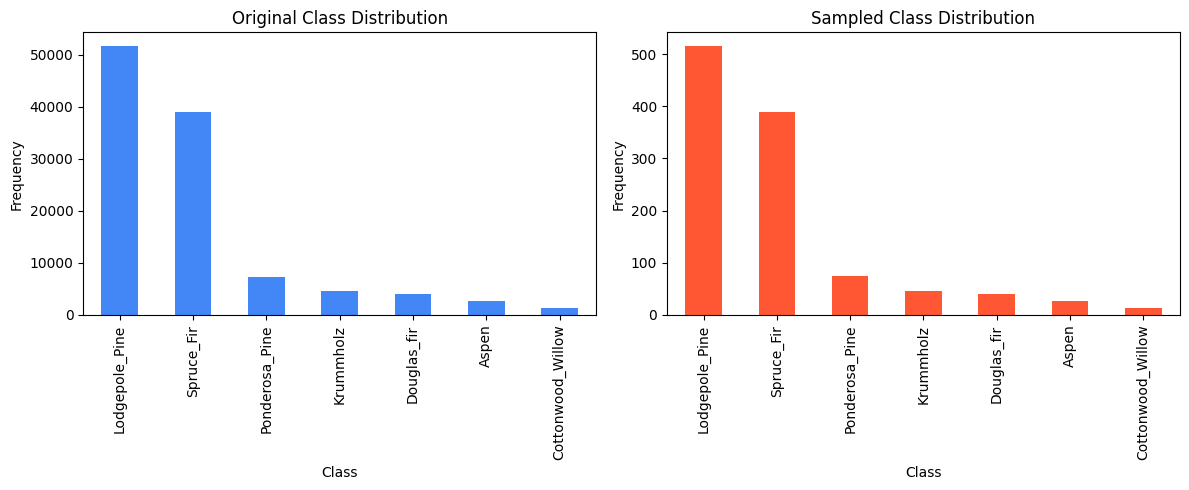

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
initial_data['class'].value_counts().plot(kind='bar', color='#4287f5')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Sampled class distribution
plt.subplot(1, 2, 2)
X_sampled['class'].value_counts().plot(kind='bar', color='#FF5733')
plt.title('Sampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
#Splitting the sampled dataset into features and target
X = X_sampled.iloc[:,:-1]
y = pd.Series(X_sampled['class'], name='target')
print(f"Number of Features : {X.shape[1]}")
print(f"Sample of Featues values : \n {X.head}")
print("#############################")
print(f"Sample of Target values : \n {y.head}")

Number of Features : 54
Sample of Featues values : 
 <bound method NDFrame.head of        elevation  aspect  slope  horizontal_distance_to_hydrology  \
29058       2988     131     20                               234   
23095       3027      67      4                               514   
95272       3073     221     10                               424   
85537       3022     171     12                                67   
16346       3174     278     13                                95   
...          ...     ...    ...                               ...   
67731       2985     169      6                               242   
84773       2811     207     24                               240   
90377       3094     297      8                               134   
12487       2942      76     12                               150   
1503        2899      61      2                               175   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
29058         

## Split the dataset into training and testing sets

**We need to explain what is spliting and why do we need it (model evaluation):**

In this classification problem, our goal is to develop a model that can accurately classify flowers based on given features. To achieve this, we need to follow a few critical steps:

(1) *Data Preprocessing* (already done).

(2) **Splitting the Dataset:** We divide the dataset into two subsets—the Training Set and the Testing Set.

(3) **Model Training:** Using the training set, we provide the model with pairs of features and their respective class labels, enabling it to learn patterns in the data and understand when to assign certain classes to specific examples (rows).

(4) **Model Testing:** Once training is complete, we evaluate the model by testing it on the testing set. This assessment helps us determine how well the model generalizes to new, unseen data (i.e., can the model correctly classify flowers it hasn’t encountered during training?).

### **Why Splitting Is Necessary**

Splitting the data is crucial for reliable model evaluation. By keeping part of the data aside for testing, we can better assess the model's ability to generalize to new data, which reflects real-world scenarios. If we were to train and test on the same data, the model might perform well simply because it has **"memorized"** the data, rather than learned **generalizable patterns**. This could lead to overfitting, where the model fails on unseen data.

**Note: For this lab, we’ll use accuracy as the performance metric. However, there are several other metrics that can provide a more comprehensive evaluation of a model’s performance, especially in cases with imbalanced classes.**

In [7]:
#Split the data set into two subsets, 80% for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

print(f"Training set's shape : {X_train.shape}")
print(f"Targets training set's shape : {y_train.shape}")
print("####################################################")
print(f"Testing set's shape : {X_test.shape}")
print(f"Targets testing set's shape : {y_test.shape}")

Training set's shape : (882, 54)
Targets training set's shape : (882,)
####################################################
Testing set's shape : (221, 54)
Targets testing set's shape : (221,)


Now, to the Feature selection methods, as mentioned before, two main categories of methods could be distinguished: Unsupervised and Supervised

# Unsupervised feature selection methods


In this section we will see three different methods; **Variance threshold**, **Correlation** and **Mutual information**

## Variance Threshold

In [8]:
def variance_threshold_selector(X, threshold=0.0):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    return X[X.columns[selector.get_support(indices=True)]]

In [9]:
print(f"Initial features: \n{X.columns.shape}, {X.columns.values}")
X_var = variance_threshold_selector(
    X_train,
    threshold=0.1
    )
print(f"Selected features Shape and names: \n{X_var.columns.shape}, {X_var.columns.values}")

Initial features: 
(54,), ['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']
Selected features Shape and names: 
(13,), ['elevation' 'aspect' 'slope' '

## Correlation

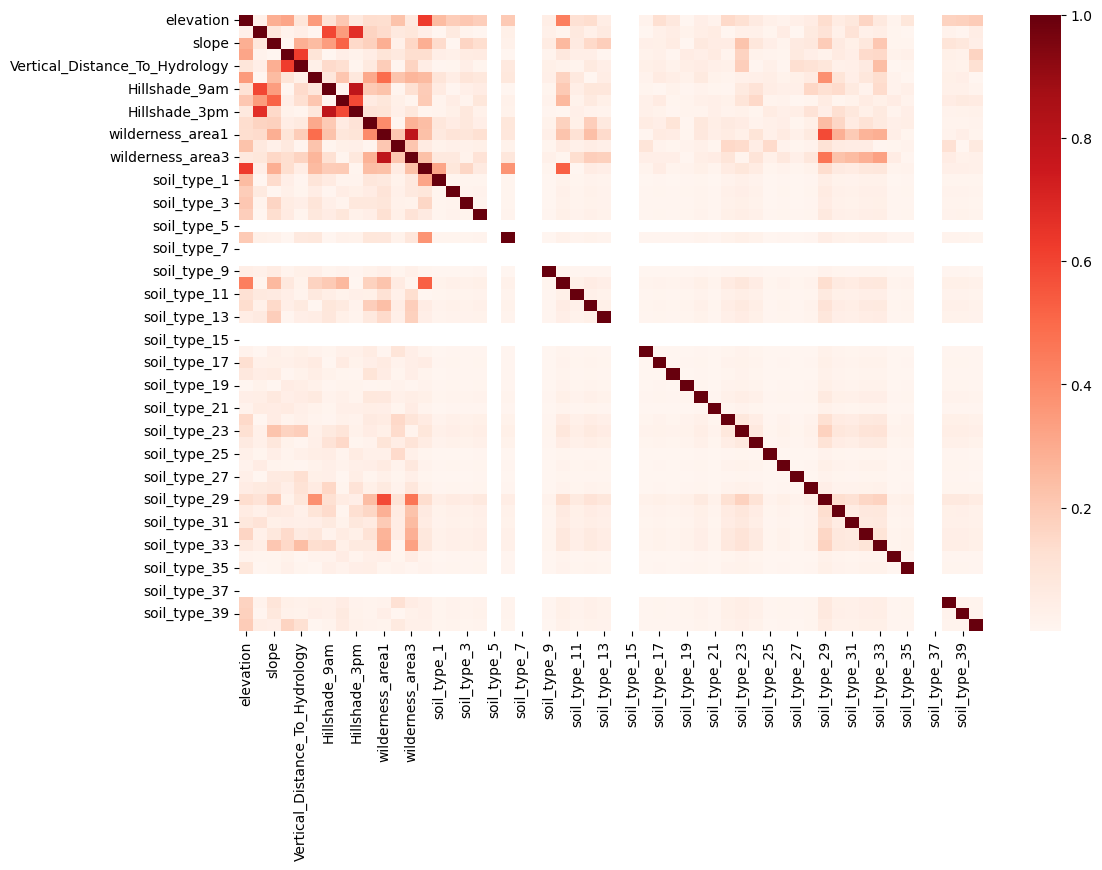

In [10]:
cor = X_train.corr().abs()
plt.figure(figsize=(12, 8))
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

In [15]:
def correlation_selector(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

In [16]:
print(f"Initial features: \n{X.columns.values}")
#Set timer start
start_time = time.time()
X_corr = correlation_selector(X_train[continuous_features.columns], threshold=0.7)
#Set timer end
end_time = time.time()
print(f"Selected features: \n{X_corr.columns.shape}, {X_corr.columns.values}")
print(f"Execution time: \n{end_time - start_time}")

Initial features: 
['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']
Selected features: 
(12,), ['elevation' 'aspect' 'slope' 'horizontal_distance_to_

## Mutual Information

Mutual information of two attributes (features or variables) A and B is the amount of information shared between them. Or how much knowing A reduces the uncertainty (Entropy) about knowing B.

Formula: $$ MI(A,B) = H(A) - H(A|B) $$

In [21]:
# Feature selection using mutual information
def mutual_info_selector(X, y, top_k=4):
    selector = SelectKBest(
        score_func=mutual_info_classif,
        k=top_k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [22]:
# Feature selection using mutual information
print(f"Initial features: \n{X.columns.values}")
#Set timer start
start_time = time.time()
X_mi = mutual_info_selector(
    X_train,
    y_train,
    top_k=20)
#Set timer end
end_time = time.time()
print(f"Selected features: \n{X_mi.columns.values}")
print(f"Execution time: \n{end_time - start_time}")


Initial features: 
['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']
Selected features: 
['elevation' 'slope' 'horizontal_distance_to_hydrology'
 'Hor

# Supervised feature selection methods

## Information Gain

In [23]:
# Feature selection using filter methods: information gain
def information_gain_selector(X, y, top_k=4):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [29]:
# Feature selection using information gain
print(f"Initial features: \n{X.columns.values}")
#Set timer start
start_time = time.time()
X_ig = information_gain_selector(X_train[categorical_features], y_train, top_k=20)
#Set timer start
end_time = time.time()
print(f"Selected features: \n{X_ig.columns.values}")
print(f"Execution time: \n{end_time - start_time}")

Initial features: 
['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']


ValueError: Input contains NaN

## Chi-squared Test

In [30]:
def chi_squared_selector(X, y, top_k=4):
    selector = SelectKBest(score_func=chi2, k=top_k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [37]:
# Feature selection using chi-squared test
print(X.columns)
X_chi2 = chi_squared_selector(X_train[categorical_features].columns, y_train, top_k=20)
print(X_chi2.columns)

Index(['elevation', 'aspect', 'slope', 'horizontal_distance_to_hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'wilderness_area1',
       'wilderness_area2', 'wilderness_area3', 'wilderness_area4',
       'soil_type_1', 'soil_type_2', 'soil_type_3', 'soil_type_4',
       'soil_type_5', 'soil_type_6', 'soil_type_7', 'soil_type_8',
       'soil_type_9', 'soil_type_10', 'soil_type_11', 'soil_type_12',
       'soil_type_13', 'soil_type_14', 'soil_type_15', 'soil_type_16',
       'soil_type_17', 'soil_type_18', 'soil_type_19', 'soil_type_20',
       'soil_type_21', 'soil_type_22', 'soil_type_23', 'soil_type_24',
       'soil_type_25', 'soil_type_26', 'soil_type_27', 'soil_type_28',
       'soil_type_29', 'soil_type_30', 'soil_type_31', 'soil_type_32',
       'soil_type_33', 'soil_type_34', 'soil_type_35', 'soil_type_36',
       'soil_type_37', 'soil

ValueError: could not convert string to float: 'elevation'

In [38]:
# Create a random forest classifier (you can replace this with any other classifier of your choice)
model = RandomForestClassifier(n_estimators=50, random_state=42, criterion="entropy")

## Feature Selection Using Wrapper Methods:

## Forward Selection

In [39]:
# Feature selection using wrapper methods: forward selection
def forward_selection(X, y, model):
    sfs = SequentialFeatureSelector(
                                    estimator=model,
                                    k_features='best',
                                    direction='forward',
                                    scoring='f1',
                                    cv=2)
    sfs.fit(X, y)
    return X[X.columns[list(sfs.k_feature_idx_)]]

In [40]:
# Feature selection using forward selection
print(f"Initial features: \n{X.columns.values}")
start_time =time.time()
X_forward = forward_selection(X_train, y_train, model)
end_time = time.time()
print(f"Selected features: \n{X_forward.columns.shape}, {X_forward.columns.values}")
print(f"Execution time: \n{end_time - start_time}")

Initial features: 
['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']


TypeError: SequentialFeatureSelector.__init__() got an unexpected keyword argument 'direction'

## Backward Elimination

In [41]:
def backward_elimination(X, y, model):
    sfs = SequentialFeatureSelector(
        estimator=model,
        k_features='best',
        direction='backward',
        scoring='f1',
        cv=2)
    sfs.fit(X, y)
    return X[X.columns[list(sfs.k_feature_idx_)]]

In [43]:
# Feature selection using backward elimination
print(f"Initial features: \n{X.columns.values}")
start_time = time.time()
X_backward = forward_selection(X_train, y_train, model)
end_time = time.time()
print(f"Selected features: \n{X_backward.columns.shape}, {X_backward.columns.values}")
print(f"Execution time: \n{end_time - start_time}")

Initial features: 
['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']


TypeError: SequentialFeatureSelector.__init__() got an unexpected keyword argument 'direction'

## Genetic Algorithm

In [44]:
def genetic_algorithm_selector(X, y, model):
    selector = GAFeatureSelectionCV(model,
                                         cv=2,
                                         scoring='accuracy',
                                         population_size=10,
                                         generations=5,
                                         tournament_size=5,
                                         elitism=True,
                                         crossover_probability=0.9,
                                         mutation_probability=0.1,
                                         criteria='max',
                                         algorithm='eaMuPlusLambda',
                                         n_jobs=3,
                                         verbose=True,
                                         keep_top_k=4)

    selector.fit(X, y)
    return X[X.columns[selector.support_]]

In [45]:
print(f"Initial features: \n{X.columns.values}")
start_time = time.time()
X_genetic = genetic_algorithm_selector(X_train, y_train, model)
end_time = time.time()
print(f"Selected features: \n{X_genetic.columns.shape}, {X_genetic.columns.values}")
print(f"Execution time: \n{end_time - start_time}")

Initial features: 
['elevation' 'aspect' 'slope' 'horizontal_distance_to_hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'wilderness_area1'
 'wilderness_area2' 'wilderness_area3' 'wilderness_area4' 'soil_type_1'
 'soil_type_2' 'soil_type_3' 'soil_type_4' 'soil_type_5' 'soil_type_6'
 'soil_type_7' 'soil_type_8' 'soil_type_9' 'soil_type_10' 'soil_type_11'
 'soil_type_12' 'soil_type_13' 'soil_type_14' 'soil_type_15'
 'soil_type_16' 'soil_type_17' 'soil_type_18' 'soil_type_19'
 'soil_type_20' 'soil_type_21' 'soil_type_22' 'soil_type_23'
 'soil_type_24' 'soil_type_25' 'soil_type_26' 'soil_type_27'
 'soil_type_28' 'soil_type_29' 'soil_type_30' 'soil_type_31'
 'soil_type_32' 'soil_type_33' 'soil_type_34' 'soil_type_35'
 'soil_type_36' 'soil_type_37' 'soil_type_38' 'soil_type_39'
 'soil_type_40']
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.589909	0.062

## --Evaluate Model performance after feature selection--

## evaluate model Function

This function aims to evaluate a given model using Training and testing subsets. It is worth noting that we can also choose other metrics to evaluate the model's performance (comparison between predicted and true values)

In [46]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) #Train the model using training sets
    y_pred = model.predict(X_test)#Predict using testing set
    accuracy = accuracy_score(y_test, y_pred)#Using Accuracy metric, Compare the predicted values with the testing target values
    return accuracy

## Compare model performance considering the selected features

In [47]:

# Concatenate the selected features of each method with the remaining non treated features (of the originial dataset)
X_variance = pd.concat(X_var)
X_correlation = pd.concat(X_corr)
X_mInformation = pd.concat(X_mi)
X_iGain = pd.concat(X_ig)
X_chiSquare = pd.concat(X_chi2)

selected_features = [X, X_variance, X_correlation, X_mInformation, X_iGain, X_chiSquare, X_forward, X_backward, X_genetic]

selected_feature_names = ['Original', 'Variance Threshold', 'Correlation', 'Mutual Information', 'Information Gain', 'Chi-squared Test', 'Forward Selection', 'Backward Elimination', 'Genetic Algorithm']

results = []

for name, X_selected in zip(selected_feature_names, selected_features):
    X_test_selected = X_selected[selected_feature_names, selected_features]  # Apply the same feature selection to the test set
    accuracy = evaluate_model(model, X_selected, X_test_selected, y_train, y_test)
    results.append({'Method': name, 'Accuracy': accuracy})

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [48]:
# Display the results
results_df = pd.DataFrame(results)
print(results_df)

NameError: name 'results' is not defined

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Method', data=results_df.sort_values(by='Accuracy', ascending=False))
plt.title('Accuracy after Feature Selection')
plt.show()

## **Q/A:** What do you notice ?

## Built in features importance  

In [ ]:
# Train the model on the whole feature set
model.fit(X_train, y_train)

importances = model.feature_importances_ # Get importance features from RandomForest model (search for it)
feature_imp_df = pd.DataFrame(
                              {'Feature': importances,
                               'Importance': importances
                               }).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 14))
plt.barh(X_train.columns.values, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Entropy Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


## Hybrid Feature selection

Think of a way to combine two feature selection methods, Perform it, and show the corresponding results.

In [ ]:
# FIX ME


## Extra task

Explore the application of PCA on the original sampled dataset;

(1) Make sure 90% of variance is maintained.

(2) Choose 2 principale components and plot the reduced data.
